In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogscats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5853961%2F9596533%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241013%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241013T140828Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D89a057aea28150a68795e7faa6332febc7b8bf06f7198ced4d5777259e973cf5d5de254f875b1c1f4ff2a621ba907178f77fb02a54c2bbd9aef42238f36a8ada56f7e5e2655352c2e4c03b683bea36f187277686bc962f45265317cd352af6a0e3bc05bd8cd12087013d0d86c15e26f7cc4e43f7cf58ad06b181ebad56794200e2ca5d9e2f3ebaf7f5ab0247dd4162d7e296fbb7089ce9eec67628e08bb193afe959b4b063e2206cd995daa8e8aabad4a3823acb918e1c6a4cb296290e594ed69747ce40422028b5ed83675d3d8b138652ba9f1578c7681019d37a81fe415d65719a4b1459ce27e7445a7d0b9ad1dcd67b521613fb728b91c28a99672f46e97c,cat-test:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5859798%2F9604404%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241013%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241013T140828Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5bc830d068706628f9831d0d095664d7e82a4f9a38beb8cc8db115772bfd7452b08f9ee667d50d9374332c008f896eb391d39d0319b58fdd0b4f3ca357f49c983b349f312aec57d0f2d6b5033b65ede5eb7b4410e349bf44b434e59ad8c7f862264b5e2c99852c4954bdb41206c8dd9dd8b788bb6cd658b66d156384759f4e32dbc11ffe43d80b2e3f5e92a270dd4cc574dc308965407e1e1d38b2ac70043f0f33bc3209d6871f5ddbb94fb9e67b113237c0943687c548199e76645897399e4538b8fc9bdd77f66659919426783a74641aa1761c4f631c7c26cd4a6a8ef7f6dc0b212b54804a358f666ef708c8a6efac69c8e92645ca6863ceb6ed78d84c8411'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 90840393 bytes downloaded
Downloaded and uncompressed: dogscats
[==================================================] 690774 bytes downloaded
Downloaded and uncompressed: cat-test
Data source import complete.


# Importing all the libraries required

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Setting up the dataset directory downloaded from Hugging Face

In [7]:
# Set up directories
base_dir = '/kaggle/input/dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
print(f"Training directory: {train_dir}")

Training directory: /kaggle/input/dogscats/subset/train


# Defining the Model as per given in Sir's Notebook

In [8]:
# Define the model
class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),  # 9x9 is the size after 4 max pooling operations
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = DogCatClassifier().to(device)
print(model)

DogCatClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10368, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)


In [9]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Set up data transformations and loaders
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20)

# Training the model for 30 epochs

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels.float()).item()
            predicted_val = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%')

Epoch [1/30], Train Loss: 0.6917, Train Accuracy: 53.70%, Val Loss: 0.6842, Val Accuracy: 54.90%
Epoch [2/30], Train Loss: 0.6748, Train Accuracy: 59.20%, Val Loss: 0.6524, Val Accuracy: 63.60%
Epoch [3/30], Train Loss: 0.6416, Train Accuracy: 63.85%, Val Loss: 0.6264, Val Accuracy: 64.50%
Epoch [4/30], Train Loss: 0.6024, Train Accuracy: 66.95%, Val Loss: 0.5967, Val Accuracy: 68.60%
Epoch [5/30], Train Loss: 0.5550, Train Accuracy: 72.80%, Val Loss: 0.6741, Val Accuracy: 61.50%
Epoch [6/30], Train Loss: 0.5395, Train Accuracy: 73.15%, Val Loss: 0.5670, Val Accuracy: 69.90%
Epoch [7/30], Train Loss: 0.5126, Train Accuracy: 75.30%, Val Loss: 0.5682, Val Accuracy: 69.70%
Epoch [8/30], Train Loss: 0.4948, Train Accuracy: 75.80%, Val Loss: 0.5426, Val Accuracy: 72.20%
Epoch [9/30], Train Loss: 0.4743, Train Accuracy: 77.85%, Val Loss: 0.5572, Val Accuracy: 70.70%
Epoch [10/30], Train Loss: 0.4554, Train Accuracy: 78.95%, Val Loss: 0.5315, Val Accuracy: 72.30%
Epoch [11/30], Train Loss: 0.

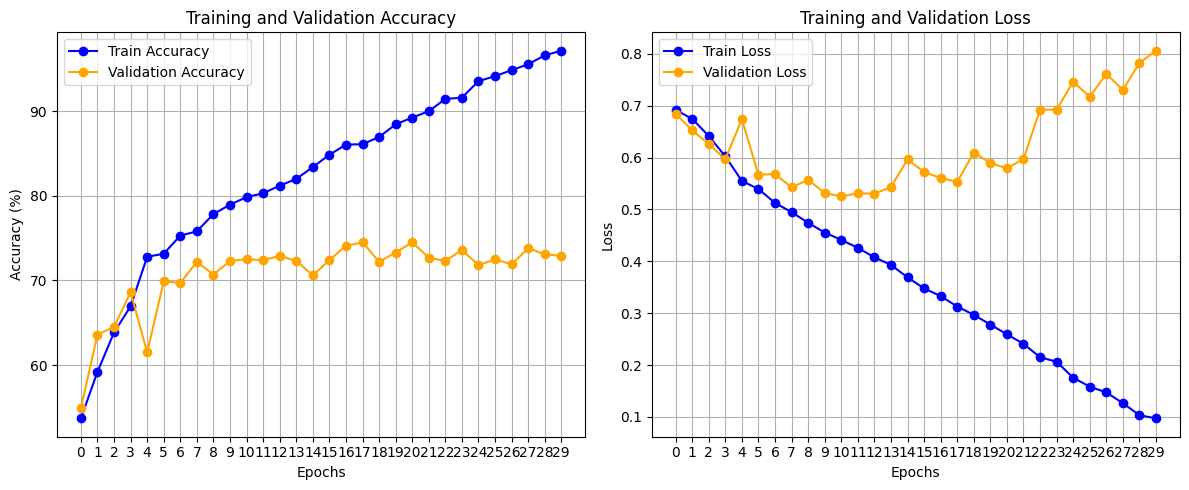

In [12]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(num_epochs))  # Set x-ticks to match the number of epochs
plt.legend()
plt.grid()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(val_losses, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(num_epochs))  # Set x-ticks to match the number of epochs
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

#

# The model on validation accuracy experiences increase in validation loss with increase in epochs and no improvement in accuracy. One thing that we can do and is also done in the given notebook is to perform augmentation so that the dataset size increases.

In [13]:

torch.save(model.state_dict(), 'dogcat_model.pth')

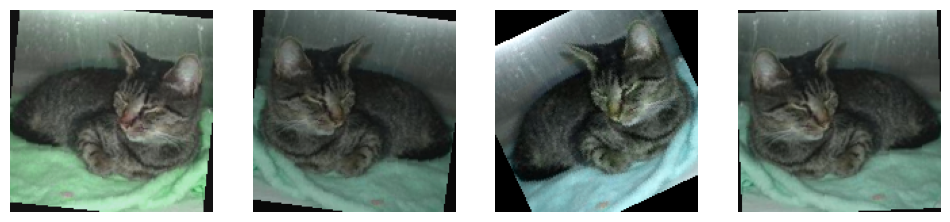

In [14]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


train_cats_dir = '/kaggle/input/dogscats/subset/train/cats'  


fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3]

img = Image.open(img_path).convert("RGB")  
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.RandomRotation(40),   
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()  
])


i = 0
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for _ in range(4):  # Generate 4 augmented images
    augmented_image = data_transforms(img)

    # Convert tensor to NumPy array for visualization
    img_array = augmented_image.numpy().transpose((1, 2, 0))  # Change shape from (C, H, W) to (H, W, C)
    axes[i].imshow(img_array)
    axes[i].axis('off')  # Hide axes
    i += 1

plt.show()


# Loading the model again which was used above to train using augmented data.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 9 * 9, 512),  
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = DogCatClassifier()

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Move model to the desired device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary (optional)
print(model)


DogCatClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=10368, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=Tru

In [16]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the data augmentation transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Crop to 150x150
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

validation_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Set your directories
train_dir = '/kaggle/input/dogscats/subset/train/'          
validation_dir = '/kaggle/input/dogscats/subset/validation/'  

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=validation_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Example of iterating through a batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print shapes
print(f'Batch shape: {images.shape}, Labels shape: {labels.shape}')


Batch shape: torch.Size([32, 3, 150, 150]), Labels shape: torch.Size([32])


In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm  

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Training settings
num_epochs = 100
train_steps_per_epoch = len(train_loader)  # Number of training batches
validation_steps = len(validation_loader)  # Number of validation batches

# Lists to store metrics
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).squeeze()  # Get model predictions
        loss = criterion(outputs, labels.float())  # Calculate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        predicted_labels = (outputs > 0.5).float()  # Apply threshold to get predicted labels
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate training loss and accuracy
    train_loss = running_loss / train_steps_per_epoch
    train_acc = correct_predictions / total_samples

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in tqdm(validation_loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).squeeze()
            val_loss = criterion(outputs, labels.float())

            # Accumulate validation loss and accuracy
            val_running_loss += val_loss.item()
            val_predicted_labels = (outputs > 0.5).float()
            val_correct_predictions += (val_predicted_labels == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate validation loss and accuracy
    val_loss = val_running_loss / validation_steps
    val_acc = val_correct_predictions / val_total_samples

    # Store metrics
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Optional: Save the model
torch.save(model.state_dict(), 'dog_cat_classifier.pth')

Validating: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s]


Epoch [1/100], Train Loss: 0.6985, Train Acc: 0.5020, Val Loss: 0.6878, Val Acc: 0.5000


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.44it/s]


Epoch [2/100], Train Loss: 0.6921, Train Acc: 0.5175, Val Loss: 0.6821, Val Acc: 0.5930


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.22it/s]


Epoch [3/100], Train Loss: 0.6817, Train Acc: 0.5665, Val Loss: 0.6615, Val Acc: 0.6180


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [4/100], Train Loss: 0.6680, Train Acc: 0.6030, Val Loss: 0.6538, Val Acc: 0.6140


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s]


Epoch [5/100], Train Loss: 0.6592, Train Acc: 0.6070, Val Loss: 0.6381, Val Acc: 0.6330


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


Epoch [6/100], Train Loss: 0.6493, Train Acc: 0.6150, Val Loss: 0.6323, Val Acc: 0.6260


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [7/100], Train Loss: 0.6389, Train Acc: 0.6370, Val Loss: 0.6596, Val Acc: 0.5750


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.17it/s]


Epoch [8/100], Train Loss: 0.6366, Train Acc: 0.6320, Val Loss: 0.6356, Val Acc: 0.6080


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.34it/s]


Epoch [9/100], Train Loss: 0.6322, Train Acc: 0.6415, Val Loss: 0.6140, Val Acc: 0.6550


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]


Epoch [10/100], Train Loss: 0.6187, Train Acc: 0.6500, Val Loss: 0.6061, Val Acc: 0.6570


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch [11/100], Train Loss: 0.6175, Train Acc: 0.6600, Val Loss: 0.5908, Val Acc: 0.6620


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.31it/s]


Epoch [12/100], Train Loss: 0.6158, Train Acc: 0.6665, Val Loss: 0.5887, Val Acc: 0.6730


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.95it/s]


Epoch [13/100], Train Loss: 0.6067, Train Acc: 0.6740, Val Loss: 0.5666, Val Acc: 0.6970


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s]


Epoch [14/100], Train Loss: 0.6108, Train Acc: 0.6715, Val Loss: 0.5666, Val Acc: 0.7080


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]


Epoch [15/100], Train Loss: 0.5961, Train Acc: 0.6805, Val Loss: 0.5581, Val Acc: 0.7070


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]


Epoch [16/100], Train Loss: 0.5919, Train Acc: 0.6755, Val Loss: 0.5589, Val Acc: 0.7010


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]


Epoch [17/100], Train Loss: 0.5868, Train Acc: 0.6850, Val Loss: 0.5585, Val Acc: 0.6940


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]


Epoch [18/100], Train Loss: 0.5934, Train Acc: 0.6800, Val Loss: 0.6199, Val Acc: 0.6590


Validating: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch [19/100], Train Loss: 0.5900, Train Acc: 0.6760, Val Loss: 0.5453, Val Acc: 0.7210


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]


Epoch [20/100], Train Loss: 0.5910, Train Acc: 0.6890, Val Loss: 0.5666, Val Acc: 0.6970


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [21/100], Train Loss: 0.5759, Train Acc: 0.6900, Val Loss: 0.5389, Val Acc: 0.7410


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s]


Epoch [22/100], Train Loss: 0.5597, Train Acc: 0.7095, Val Loss: 0.5444, Val Acc: 0.7230


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.93it/s]


Epoch [23/100], Train Loss: 0.5705, Train Acc: 0.7035, Val Loss: 0.5311, Val Acc: 0.7370


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]


Epoch [24/100], Train Loss: 0.5618, Train Acc: 0.7135, Val Loss: 0.6045, Val Acc: 0.6770


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]


Epoch [25/100], Train Loss: 0.5534, Train Acc: 0.7190, Val Loss: 0.5168, Val Acc: 0.7390


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]


Epoch [26/100], Train Loss: 0.5644, Train Acc: 0.7115, Val Loss: 0.5070, Val Acc: 0.7580


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


Epoch [27/100], Train Loss: 0.5561, Train Acc: 0.7070, Val Loss: 0.5764, Val Acc: 0.7020


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s]


Epoch [28/100], Train Loss: 0.5579, Train Acc: 0.7105, Val Loss: 0.5443, Val Acc: 0.7090


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.44it/s]


Epoch [29/100], Train Loss: 0.5628, Train Acc: 0.7060, Val Loss: 0.5114, Val Acc: 0.7420


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.18it/s]


Epoch [30/100], Train Loss: 0.5536, Train Acc: 0.7075, Val Loss: 0.5820, Val Acc: 0.6940


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.60it/s]


Epoch [31/100], Train Loss: 0.5581, Train Acc: 0.7120, Val Loss: 0.5035, Val Acc: 0.7600


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


Epoch [32/100], Train Loss: 0.5574, Train Acc: 0.7040, Val Loss: 0.4754, Val Acc: 0.7750


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]


Epoch [33/100], Train Loss: 0.5344, Train Acc: 0.7275, Val Loss: 0.5158, Val Acc: 0.7320


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]


Epoch [34/100], Train Loss: 0.5319, Train Acc: 0.7455, Val Loss: 0.5043, Val Acc: 0.7470


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.41it/s]


Epoch [35/100], Train Loss: 0.5439, Train Acc: 0.7190, Val Loss: 0.4719, Val Acc: 0.7820


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s]


Epoch [36/100], Train Loss: 0.5329, Train Acc: 0.7315, Val Loss: 0.5239, Val Acc: 0.7420


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]


Epoch [37/100], Train Loss: 0.5256, Train Acc: 0.7340, Val Loss: 0.4803, Val Acc: 0.7680


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [38/100], Train Loss: 0.5345, Train Acc: 0.7385, Val Loss: 0.4698, Val Acc: 0.7930


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


Epoch [39/100], Train Loss: 0.5237, Train Acc: 0.7400, Val Loss: 0.4637, Val Acc: 0.7860


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.52it/s]


Epoch [40/100], Train Loss: 0.5273, Train Acc: 0.7415, Val Loss: 0.4885, Val Acc: 0.7690


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [41/100], Train Loss: 0.5165, Train Acc: 0.7420, Val Loss: 0.4729, Val Acc: 0.7710


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch [42/100], Train Loss: 0.5108, Train Acc: 0.7495, Val Loss: 0.4495, Val Acc: 0.7880


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]


Epoch [43/100], Train Loss: 0.5070, Train Acc: 0.7505, Val Loss: 0.4784, Val Acc: 0.7640


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.66it/s]


Epoch [44/100], Train Loss: 0.5042, Train Acc: 0.7595, Val Loss: 0.4938, Val Acc: 0.7560


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s]


Epoch [45/100], Train Loss: 0.4986, Train Acc: 0.7505, Val Loss: 0.4578, Val Acc: 0.7870


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.42it/s]


Epoch [46/100], Train Loss: 0.5093, Train Acc: 0.7475, Val Loss: 0.5195, Val Acc: 0.7200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]


Epoch [47/100], Train Loss: 0.4931, Train Acc: 0.7605, Val Loss: 0.4418, Val Acc: 0.8010


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


Epoch [48/100], Train Loss: 0.4903, Train Acc: 0.7585, Val Loss: 0.5218, Val Acc: 0.7340


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.87it/s]


Epoch [49/100], Train Loss: 0.4961, Train Acc: 0.7610, Val Loss: 0.4577, Val Acc: 0.7790


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.37it/s]


Epoch [50/100], Train Loss: 0.4761, Train Acc: 0.7680, Val Loss: 0.5696, Val Acc: 0.7330


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]


Epoch [51/100], Train Loss: 0.4820, Train Acc: 0.7720, Val Loss: 0.4410, Val Acc: 0.8030


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]


Epoch [52/100], Train Loss: 0.4828, Train Acc: 0.7670, Val Loss: 0.4853, Val Acc: 0.7800


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]


Epoch [53/100], Train Loss: 0.4982, Train Acc: 0.7545, Val Loss: 0.4373, Val Acc: 0.7960


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s]


Epoch [54/100], Train Loss: 0.4825, Train Acc: 0.7575, Val Loss: 0.6108, Val Acc: 0.7050


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]


Epoch [55/100], Train Loss: 0.4800, Train Acc: 0.7705, Val Loss: 0.4568, Val Acc: 0.7910


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.34it/s]


Epoch [56/100], Train Loss: 0.4618, Train Acc: 0.7745, Val Loss: 0.4383, Val Acc: 0.8060


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]


Epoch [57/100], Train Loss: 0.4819, Train Acc: 0.7670, Val Loss: 0.4378, Val Acc: 0.8060


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


Epoch [58/100], Train Loss: 0.4555, Train Acc: 0.7910, Val Loss: 0.4296, Val Acc: 0.7940


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]


Epoch [59/100], Train Loss: 0.4763, Train Acc: 0.7685, Val Loss: 0.4375, Val Acc: 0.8150


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.24it/s]


Epoch [60/100], Train Loss: 0.4722, Train Acc: 0.7705, Val Loss: 0.6432, Val Acc: 0.6720


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]


Epoch [61/100], Train Loss: 0.4491, Train Acc: 0.7810, Val Loss: 0.4278, Val Acc: 0.8090


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]


Epoch [62/100], Train Loss: 0.4660, Train Acc: 0.7755, Val Loss: 0.4502, Val Acc: 0.7930


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


Epoch [63/100], Train Loss: 0.4498, Train Acc: 0.7940, Val Loss: 0.4600, Val Acc: 0.8040


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.76it/s]


Epoch [64/100], Train Loss: 0.4564, Train Acc: 0.7790, Val Loss: 0.4233, Val Acc: 0.8020


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


Epoch [65/100], Train Loss: 0.4514, Train Acc: 0.7860, Val Loss: 0.4253, Val Acc: 0.8190


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s]


Epoch [66/100], Train Loss: 0.4460, Train Acc: 0.7905, Val Loss: 0.4245, Val Acc: 0.8100


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s]


Epoch [67/100], Train Loss: 0.4562, Train Acc: 0.7815, Val Loss: 0.5334, Val Acc: 0.7380


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [68/100], Train Loss: 0.4434, Train Acc: 0.7985, Val Loss: 0.4258, Val Acc: 0.8150


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch [69/100], Train Loss: 0.4410, Train Acc: 0.7990, Val Loss: 0.4201, Val Acc: 0.8100


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


Epoch [70/100], Train Loss: 0.4396, Train Acc: 0.7985, Val Loss: 0.4413, Val Acc: 0.8050


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]


Epoch [71/100], Train Loss: 0.4314, Train Acc: 0.7955, Val Loss: 0.4188, Val Acc: 0.8120


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]


Epoch [72/100], Train Loss: 0.4250, Train Acc: 0.8015, Val Loss: 0.4978, Val Acc: 0.7720


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.20it/s]


Epoch [73/100], Train Loss: 0.4401, Train Acc: 0.7995, Val Loss: 0.4065, Val Acc: 0.8220


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.94it/s]


Epoch [74/100], Train Loss: 0.4171, Train Acc: 0.8020, Val Loss: 0.4534, Val Acc: 0.7910


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.60it/s]


Epoch [75/100], Train Loss: 0.4289, Train Acc: 0.7970, Val Loss: 0.4163, Val Acc: 0.8250


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch [76/100], Train Loss: 0.4266, Train Acc: 0.8035, Val Loss: 0.4093, Val Acc: 0.8190


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]


Epoch [77/100], Train Loss: 0.4405, Train Acc: 0.8010, Val Loss: 0.4679, Val Acc: 0.7800


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]


Epoch [78/100], Train Loss: 0.4226, Train Acc: 0.8070, Val Loss: 0.5343, Val Acc: 0.7530


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.61it/s]


Epoch [79/100], Train Loss: 0.4210, Train Acc: 0.8005, Val Loss: 0.4021, Val Acc: 0.8220


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]


Epoch [80/100], Train Loss: 0.4251, Train Acc: 0.8085, Val Loss: 0.4299, Val Acc: 0.7920


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]


Epoch [81/100], Train Loss: 0.4180, Train Acc: 0.8070, Val Loss: 0.3852, Val Acc: 0.8330


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.18it/s]


Epoch [82/100], Train Loss: 0.4107, Train Acc: 0.8140, Val Loss: 0.4905, Val Acc: 0.7770


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]


Epoch [83/100], Train Loss: 0.4120, Train Acc: 0.8070, Val Loss: 0.3880, Val Acc: 0.8380


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]


Epoch [84/100], Train Loss: 0.4196, Train Acc: 0.8060, Val Loss: 0.4243, Val Acc: 0.8070


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s]


Epoch [85/100], Train Loss: 0.4013, Train Acc: 0.8110, Val Loss: 0.4173, Val Acc: 0.8080


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.57it/s]


Epoch [86/100], Train Loss: 0.3842, Train Acc: 0.8220, Val Loss: 0.3735, Val Acc: 0.8400


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s]


Epoch [87/100], Train Loss: 0.4155, Train Acc: 0.8065, Val Loss: 0.4277, Val Acc: 0.8190


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]


Epoch [88/100], Train Loss: 0.3914, Train Acc: 0.8175, Val Loss: 0.4791, Val Acc: 0.7800


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.32it/s]


Epoch [89/100], Train Loss: 0.4041, Train Acc: 0.8140, Val Loss: 0.4823, Val Acc: 0.7820


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch [90/100], Train Loss: 0.3872, Train Acc: 0.8205, Val Loss: 0.4100, Val Acc: 0.8200


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]


Epoch [91/100], Train Loss: 0.4043, Train Acc: 0.8175, Val Loss: 0.4140, Val Acc: 0.8230


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s]


Epoch [92/100], Train Loss: 0.3883, Train Acc: 0.8250, Val Loss: 0.4291, Val Acc: 0.8120


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]


Epoch [93/100], Train Loss: 0.3970, Train Acc: 0.8200, Val Loss: 0.3781, Val Acc: 0.8390


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


Epoch [94/100], Train Loss: 0.3806, Train Acc: 0.8265, Val Loss: 0.3898, Val Acc: 0.8230


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]


Epoch [95/100], Train Loss: 0.3809, Train Acc: 0.8295, Val Loss: 0.5125, Val Acc: 0.7740


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


Epoch [96/100], Train Loss: 0.3766, Train Acc: 0.8280, Val Loss: 0.3671, Val Acc: 0.8450


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]


Epoch [97/100], Train Loss: 0.3763, Train Acc: 0.8275, Val Loss: 0.3824, Val Acc: 0.8300


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


Epoch [98/100], Train Loss: 0.3893, Train Acc: 0.8195, Val Loss: 0.3986, Val Acc: 0.8240


Validating: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]


Epoch [99/100], Train Loss: 0.3660, Train Acc: 0.8295, Val Loss: 0.4007, Val Acc: 0.8270


Validating: 100%|██████████| 32/32 [00:03<00:00, 10.48it/s]

Epoch [100/100], Train Loss: 0.3747, Train Acc: 0.8310, Val Loss: 0.5309, Val Acc: 0.7520


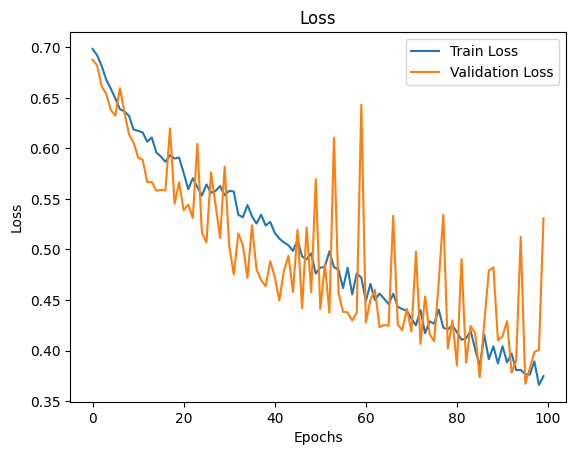

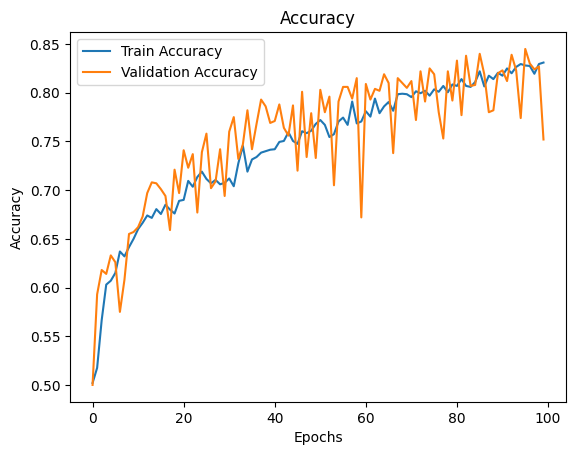

In [18]:
# Optional: Plotting training and validation loss/accuracy
import matplotlib.pyplot as plt

# Plot loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# We can clearly see that the probem of overfitting and increase in validation loss has been solved. The performance of this model looks decent enough.

100%|██████████| 32/32 [00:03<00:00,  9.49it/s]


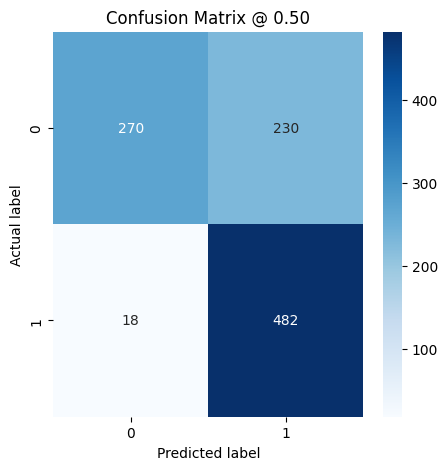

True Negatives:  270
False Positives:  230
False Negatives:  18
True Positives:  482


100%|██████████| 32/32 [00:03<00:00,  9.78it/s]

Validation Loss: 0.5309, Validation Accuracy: 0.7520


In [19]:
import torch
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Assuming `model`, `train_loader`, and `validation_loader` are defined

# Function to plot confusion matrix
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels.cpu(), (predictions > threshold).cpu())
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix @ {:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])

# Function to gather predictions and labels for a dataset
def get_predictions_and_labels(loader, model, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get model predictions
            outputs = model(images).squeeze()

            all_predictions.append(outputs)
            all_labels.append(labels)

    # Concatenate all the predictions and labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    return all_predictions, all_labels

# Get predictions and labels for the train and validation sets
train_predictions, train_labels = get_predictions_and_labels(train_loader, model, device)
val_predictions, val_labels = get_predictions_and_labels(validation_loader, model, device)

# Plot confusion matrix and ROC curve for the validation set
plot_cm(val_labels, val_predictions)

# Optional: Evaluate baseline metrics (loss, accuracy)
def evaluate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())

            running_loss += loss.item()
            predicted_labels = (outputs > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    loss = running_loss / len(loader)
    accuracy = correct_predictions / total_samples

    return loss, accuracy

# Evaluate baseline on validation data
criterion = nn.BCELoss()  # Assuming binary classification
val_loss, val_acc = evaluate(validation_loader, model, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Call the function with binary labels and predictions


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Get predictions from the model for training and validation datasets
def get_predictions(loader):
    all_predictions = []
    all_labels = []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Get predictions for training and validation datasets
train_labels, train_predictions_baseline = get_predictions(train_loader)
val_labels, test_predictions_baseline = get_predictions(validation_loader)

# Plot ROC Curve for Train and Validation Set
plt.figure(figsize=(10, 6))
plot_roc("Train Baseline", train_labels, train_predictions_baseline)
plot_roc("Validation Baseline", val_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')
plt.title('ROC Curves')
plt.show()


#1. Further now is the representation of explainer algorithm and their implementation

#(a). We know that the AI models that we trained above are some what blackboxes and it's difficult to understand how they arrive at their predictions. Here we use Explainer Algorthims to help increase trust in these models by providing insights into their decision-making process.

#(b) As given in the assignment we have to implement two Explainer Algorithms
# 1.   Integrated Gradients
#2.   Grad Cam


# First we implement Integrated Gradient

In [ ]:
!pip install captum

In [22]:
# Assuming your model is saved as 'model.pth'
model = DogCatClassifier()
model.load_state_dict(torch.load('dog_cat_classifier.pth'))
model.to(device)  # Ensure it’s on the correct device (GPU/CPU)
model.eval()  # Set model to evaluation mode

<ipython-input-22-47ea9c19f1eb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dog_cat_classifier.pth'))


DogCatClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=10368, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=Tru

# Integrated Gradients

##We use it to understand which parts of an image are important for a model’s decision. For example, if the model thinks the image is of a cat, which pixels or parts of the cat image are most important in making that decision?

#Step-by-Step Explanation:
##Baseline Selection:

The baseline is usually a completely black image (all pixel values are 0).
This black image serves as the starting point, representing "nothing" or no information for the model.
##Equation: Baseline = 0
(a black image)

#Interpolation:

We create several images by blending the baseline (black image) with the original input image. Think of it as slowly fading the original image in from black.

Mathematically, for an image
𝑥 and baseline 𝑥′, we create images that are a mixture of the two:
#Interpolated image = 𝑥 ′ + 𝛼 ( 𝑥 − 𝑥 ′ ) where 𝛼 varies from 0 to 1.
For example, with 𝛼 = 0.5, we get an image that is halfway between the black image and the original.

#Gradient Calculation
For each of the interpolated images, we compute the model's output and calculate the gradient.

The gradient
∇
𝐹
(
𝑥
)
tells us how sensitive the model’s prediction is to each pixel of the image. If the gradient is large for a pixel, it indicates that the pixel is important for the model's decision.

If $( F(x) $\) is the model’s prediction (probability) for a class, then:
#$[
\nabla F(x) = \left( \frac{\partial F(x)}{\partial x_1}, \frac{\partial F(x)}{\partial x_2}, \ldots, \frac{\partial F(x)}{\partial x_n} \right)
$\]
where $( x_1, x_2, \ldots, x_n $\) are the pixels.


#Attribution Calculation

Once we have gradients for all the interpolated images, we average them to obtain the Integrated Gradients, which represent how important each pixel is to the final decision.

The Integrated Gradients formula is:

#$[
\text{Attribution} = (x - x') \times \int_0^1 \nabla F\left(x' + \alpha (x - x')\right) d\alpha
$\]
In simpler terms, we combine the gradient information for each interpolated image and multiply it by how much the pixel changes from the baseline to the input image.


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def visualize_integrated_gradients(input_tensor, model, target_class=0, n_steps=50):

    ig = IntegratedGradients(model)

 
    baseline = torch.zeros_like(input_tensor).to(input_tensor.device)

    attributions, delta = ig.attribute(input_tensor, baseline, target=target_class, n_steps=n_steps, return_convergence_delta=True)

    attributions = attributions.cpu().detach().numpy()[0].transpose(1, 2, 0)
    input_image = input_tensor.cpu().detach().numpy()[0].transpose(1, 2, 0)

    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (0.25, '#0000ff'),
                                                      (1, '#0000ff')], N=256)

 
    _ = viz.visualize_image_attr(None, input_image, method="original_image", title="Original Image")

    _ = viz.visualize_image_attr(attributions,
                                 input_image,
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 title='Integrated Gradients')


sample_input, _ = next(iter(val_loader))  # Get a sample input from validation loader
sample_input = sample_input.to(device)
visualize_integrated_gradients(sample_input, model, target_class=0)  # Assuming class 0 is 'cat'


##The image output from the Integrated Gradients method shows two parts:

a. Original Image (Top): This is the input image of a cat used to understand which parts are important for the model's prediction.

b. Integrated Gradients Heatmap (Bottom): The blue heatmap represents pixel attributions based on the Integrated Gradients method. The color intensity in the heatmap signifies the importance of each pixel to the model's decision.

Interpretation of Blue Areas: The pixels that are highlighted in blue indicate the areas that contribute to the model's prediction (in this case, classifying the image as a cat).

# GradCam Implementation

#1. Target Layer Selection:

Identify the last convolutional layer of your model. This layer is crucial because it retains spatial information that can be visualized.
For instance, if your model's architecture has several convolutional layers, you might choose the 9th layer as your target layer.

#2. Initialize Grad-CAM:

Use the LayerGradCam class from Captum, passing the model and the target layer.
This class will compute the gradients and help create the Grad-CAM visualizations.

#3. Generate Grad-CAM Attributions:

#a. For a given input image (or tensor), compute the Grad-CAM attributions. This step involves:
Calculating the gradients of the predicted class score concerning the output of the target layer.
The output gradients are then averaged over the spatial dimensions to get a single value per feature map.

Calculating the gradients of the predicted class score $( y^c $\) with respect to the feature maps of the target convolutional layer $( A^k $\).

The gradients $( \frac{\partial y^c}{\partial A^k} $\) indicate how the class score changes with respect to each feature map activation.

#b. Grad-CAM Equation:

The Grad-CAM equation is:

#$[
L_{\text{Grad-CAM}}^c = \text{ReLU} \left( \sum_k \alpha_k^c A^k \right)
$]

where $( L_{\text{Grad-CAM}}^c $\) is the Grad-CAM heatmap for class $( c $\), $( A^k $\) is the $( k $\)-th feature map in the selected layer, and $( \alpha_k^c $\) is the importance weight for the $( k $\)-th feature map.

#c. Importance Weight Calculation:

The importance weight $( \alpha_k^c $\) is computed as:

$[
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}
$\]

where $( Z $\) is the number of pixels (i.e., spatial locations) in the feature map, and the summation is over the spatial dimensions $( i $\) and $( j $\).


#4. Interpolate the Attributions:

The generated attributions need to be resized to match the input image size. This is achieved using interpolation.
The interpolated attributions will highlight the regions of the image that contribute most to the model's decision.

#5. Visualize Grad-CAM:

Utilize Captum's visualization utilities to show the original image, the Grad-CAM heatmap, and a masked version of the image.
You can visualize multiple types of attributions, such as positive and negative attributions, to understand what features are contributing to the model's predictions.

#6.Prepare for Visualization:

Convert the attributions and the input image into a suitable format for visualization. This typically involves changing the shape and type of the tensors.
Use NumPy to rearrange the dimensions of the tensors for visualization.

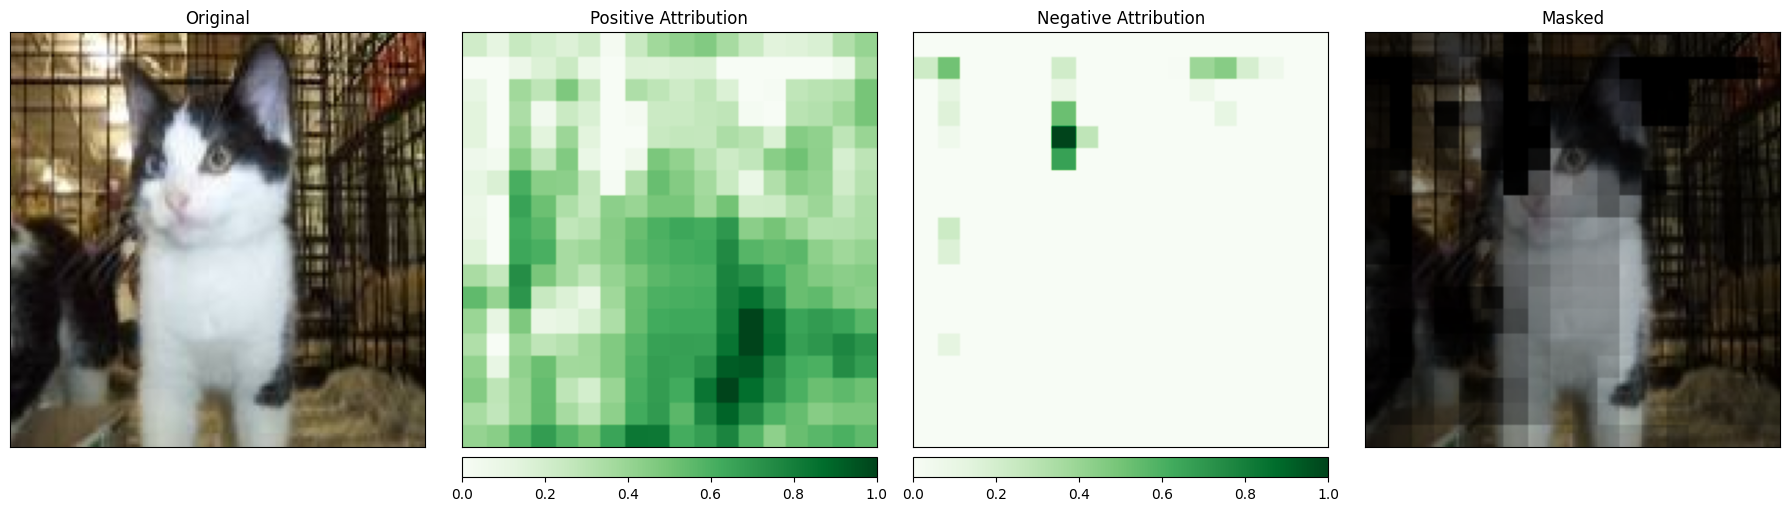

In [33]:
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import torch
import numpy as np

def visualize_grad_cam(input_tensor, model, target_class=0):
    # Target the last convolutional layer in your model (update this according to your model structure)
    target_layer = model.conv_layers[9]  # Adjust based on your model

    grad_cam = LayerGradCam(model, target_layer)

    attributions = grad_cam.attribute(input_tensor, target=target_class)

    upsampled_attributions = LayerAttribution.interpolate(attributions, input_tensor.shape[2:])

    attributions_np = upsampled_attributions[0].cpu().permute(1, 2, 0).detach().numpy()
    input_image_np = input_tensor[0].cpu().permute(1, 2, 0).detach().numpy()


    _ = viz.visualize_image_attr_multiple(
        attributions_np,
        input_image_np,
        ["original_image", "heat_map", "heat_map", "masked_image"],
        ["all", "negative", "positive", "negative"],
        show_colorbar=True,
        titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
        fig_size=(18, 6),
        cmap='Greens'
    )

# Example usage with a sample input from our dataset
sample_input, _ = next(iter(val_loader))
sample_input = sample_input.to(device)
visualize_grad_cam(sample_input, model, target_class=0)


# in the above images it can be seen that positive attribution is dense near the cat face and body indicating it got reference from there


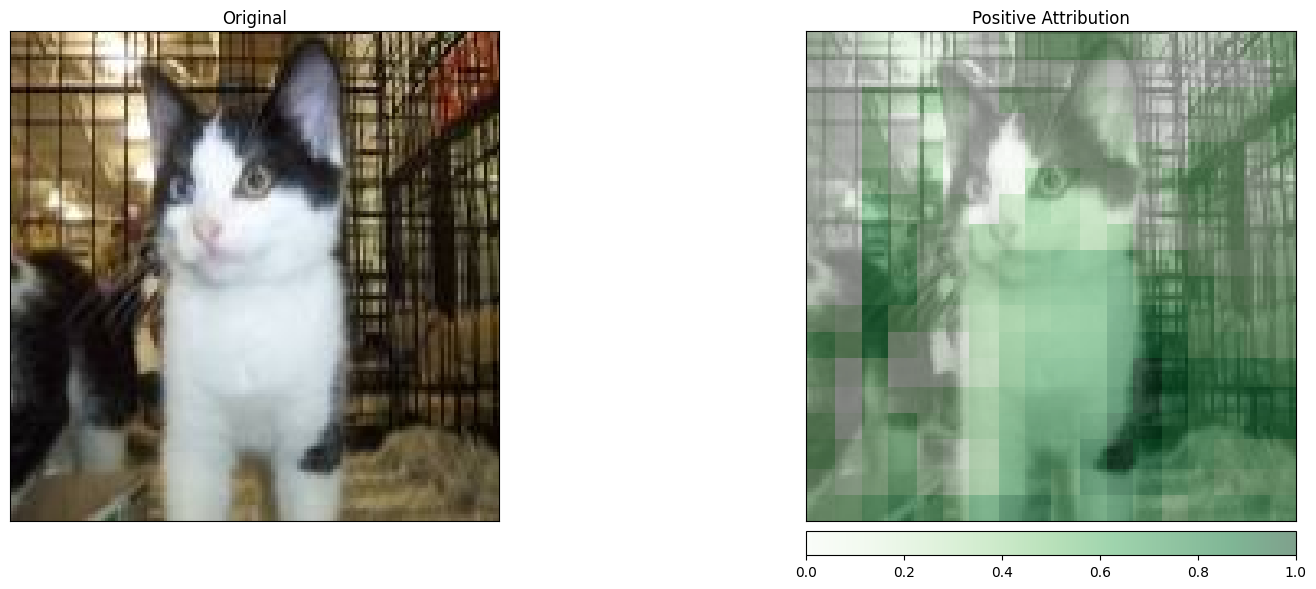

In [41]:
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import torch
import numpy as np


def visualize_grad_cam(input_tensor, model, target_class=0):
    
    target_layer = model.conv_layers[9]  # Adjust based on your model

    grad_cam = LayerGradCam(model, target_layer)
    attributions = grad_cam.attribute(input_tensor, target=target_class)
    upsampled_attributions = LayerAttribution.interpolate(attributions, input_tensor.shape[2:])
    attributions_np = upsampled_attributions[0].cpu().permute(1, 2, 0).detach().numpy()
    input_image_np = input_tensor[0].cpu().permute(1, 2, 0).detach().numpy()
    _ = viz.visualize_image_attr_multiple(attributions_np,
                                          input_image_np,
                                          ["original_image", "blended_heat_map"],
                                          ["all", "negative"],  
                                          show_colorbar=True,
                                          titles=["Original", "Attribution"],
                                          fig_size=(18, 6),
                                          cmap='Greens')

sample_input, _ = next(iter(val_loader))
sample_input = sample_input.to(device)
visualize_grad_cam(sample_input, model, target_class=0)


# we can see theat the attribuion overlays with the cats body and face.